# Exploratory Data Analysis of US RCC Dataset

## Imports

In [91]:
SEED = 42

import tensorflow as tf
import pandas as pd 
import numpy as np
np.random.seed(SEED)
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import sklearn
import plotly.graph_objects as go
import plotly.express as px
from time import time
import json
import warnings
%matplotlib inline

In [92]:
# Accelerate SKL for Intel
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Load dataset

<Axes: >

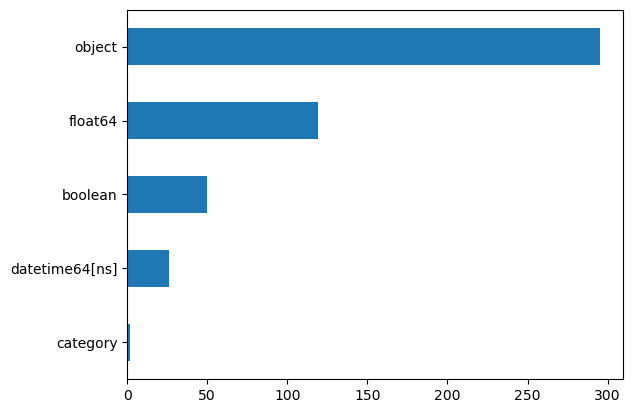

In [93]:
rcc = pd.read_pickle('../Data Sources/Cleaned/US_RCC_Database_CLEANED.pkl')
# Check to make sure dtypes persisted
rcc.dtypes.value_counts().sort_values().plot(kind = 'barh')

## TODO: Visualization w/ Alluvial Diagrams

Ultimate goal is to forecast treatment paths at an individual level using a NN. Here, we will demonstrate what this looks like at the population level. 
* Begin with anastomotic leak as end goal
* Break up path along stages of treatment
* We can take a stepwise regression/decision tree approach to add the most 'descriminant' features one at a time. Couple w/ statistical tests and display significance on chart
* Need to handle different dtypes
    * Treat num vals as parallel sets
    * NaNs as own cat
    * Might need to break up chemo regimens along y-axis

### Reproduce Ali et. al. (2024) findings on OFP -> Leak

Num samples: 825

Independent Variable:
Omental Flap to Pelvis
no     722
yes    103
Name: count, dtype: int64

Dependent Variable:
Anastomotic Leak
no     446
NaN    338
yes     41
Name: count, dtype: int64

Summary of selected demographic stats:


array([[<Axes: xlabel='Age', ylabel='Age'>,
        <Axes: xlabel='Height (cm)', ylabel='Age'>,
        <Axes: xlabel='Weight (kg)', ylabel='Age'>,
        <Axes: xlabel='BMI', ylabel='Age'>],
       [<Axes: xlabel='Age', ylabel='Height (cm)'>,
        <Axes: xlabel='Height (cm)', ylabel='Height (cm)'>,
        <Axes: xlabel='Weight (kg)', ylabel='Height (cm)'>,
        <Axes: xlabel='BMI', ylabel='Height (cm)'>],
       [<Axes: xlabel='Age', ylabel='Weight (kg)'>,
        <Axes: xlabel='Height (cm)', ylabel='Weight (kg)'>,
        <Axes: xlabel='Weight (kg)', ylabel='Weight (kg)'>,
        <Axes: xlabel='BMI', ylabel='Weight (kg)'>],
       [<Axes: xlabel='Age', ylabel='BMI'>,
        <Axes: xlabel='Height (cm)', ylabel='BMI'>,
        <Axes: xlabel='Weight (kg)', ylabel='BMI'>,
        <Axes: xlabel='BMI', ylabel='BMI'>]], dtype=object)

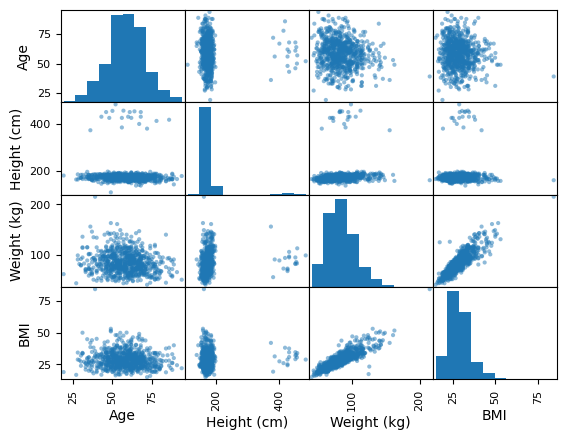

In [94]:
# Include patients w/ LAR and non-missing OFP data
leak_mvp = rcc[(rcc['Type of Operation of Rectal Tumor'] == 'lar') & rcc['Omental Flap to Pelvis'].notna()]

# Generate some summary stats
print("Num samples:", len(leak_mvp))
print("\nIndependent Variable:")
print(leak_mvp['Omental Flap to Pelvis'].value_counts(dropna=False))
print("\nDependent Variable:")
print(leak_mvp['Anastomotic Leak'].value_counts(dropna=False))
print("\nSummary of selected demographic stats:")
demo_feats = [  'Gender',
                'Age',
                'Race',
                'Height (cm)',
                'Weight (kg)',
                'BMI',
                'Health Insurance',
                'ASA Class',
                'Functional Status',
                'Family history of CRC',
                'Date of Diagnosis',
                'Primary v. Recurrence',
                'Omental Flap to Pelvis',
                'Anastomotic Leak']
pd.plotting.scatter_matrix(leak_mvp[demo_feats])

In [95]:
# For each feature of interest, connect unique values to the unique values of the previous feature.
# Set weight by proportional frequency
feats = ['Gender', 'Bowel Obstruction', 'Diabetes', 'Neoadjuvant Chemoradiation', 'Operative Approach', 'Omental Flap to Pelvis', 'Anastomotic Leak']
response = 'Anastomotic Leak'

labels = []
sources = []
targets = []
values = []
p_values = []

val_counts = []
for i, feat in enumerate(feats):
    val_counts.append(leak_mvp[feat].value_counts(dropna=False).sort_values(ascending=False))
    unique_vals = list(val_counts[i].index)
    labels.extend([feat + ': ' + str(val) for val in unique_vals])
    if (feat is not response):
        contingency_tab = pd.crosstab(leak_mvp[feat], leak_mvp[response], margins=False, dropna=False)
    if (i > 0):
        prior_unique_vals = list(val_counts[i - 1].index)
        for j, value in enumerate(unique_vals):
            for k, prior_value in enumerate(prior_unique_vals):
                # Count num samples with both values
                if (isinstance(value, float) and np.isnan(value)): 
                    value_mask = leak_mvp[feat].isna()
                else: value_mask = leak_mvp[feat] == value
                
                if (isinstance(prior_value, float) and np.isnan(prior_value)): 
                    prior_value_mask = leak_mvp[feats[i-1]].isna()
                else: prior_value_mask = leak_mvp[feats[i-1]] == prior_value

                values.append(len(leak_mvp[(value_mask) & (prior_value_mask)]) / len(leak_mvp))
                # Set source: index labels by -1 * (len(val_counts) + len(prior_val_counts) - k)
                sources.append(labels.index(labels[-1 * (len(unique_vals) + len(prior_unique_vals) - k)]))
                # Set target: index labels by -1 * (len(val_counts) - j)
                targets.append(labels.index(labels[-1 * (len(unique_vals) - j)]))

In [96]:
print(labels)
print(sources)
print(targets)
print(values)
sum(values)

['Gender: male', 'Gender: female', 'Gender: nan', 'Bowel Obstruction: nan', 'Bowel Obstruction: large bowel obstruction', 'Bowel Obstruction: partial small bowel obstruction', 'Diabetes: no', 'Diabetes: yes', 'Diabetes: nan', 'Neoadjuvant Chemoradiation: yes', 'Neoadjuvant Chemoradiation: no', 'Neoadjuvant Chemoradiation: nan', 'Operative Approach: hand-assist', 'Operative Approach: open', 'Operative Approach: laparoscopic', 'Operative Approach: hybrid', 'Operative Approach: robotic', 'Operative Approach: conversion to open', 'Operative Approach: nan', 'Operative Approach: not applicable', 'Omental Flap to Pelvis: no', 'Omental Flap to Pelvis: yes', 'Anastomotic Leak: no', 'Anastomotic Leak: nan', 'Anastomotic Leak: yes']
[0, 1, 2, 0, 1, 2, 0, 1, 2, 3, 4, 5, 3, 4, 5, 3, 4, 5, 6, 7, 8, 6, 7, 8, 6, 7, 8, 9, 10, 11, 9, 10, 11, 9, 10, 11, 9, 10, 11, 9, 10, 11, 9, 10, 11, 9, 10, 11, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 20, 21, 20, 21]
[3, 3, 3, 

6.000000000000001

In [97]:
# Create sankey/alluvial diagram
# Load color dict
with open('../Data Sources/Cleaned/color_dict.json') as fp:
  color_dict = json.load(fp)

fig = go.Figure(data=[go.Sankey(
  valueformat = ".2%",
  node = dict(
    pad = 15,
    thickness = 20,
    line = dict(color = "black", width = 0.5),
    label = labels,
    color = [color_dict[label.split(':')[0]] for label in labels]
  ),
  link = dict(
    source = sources, # indices correspond to labels, eg A1, A2, A1, B1, ...
    target = targets,
    value = values
  ))])

fig.update_layout(title_text="Basic Sankey Diagram", font_size=10)
fig.show()

### Improvements
* Build ML model (MLR, SVM, DT) with features and report result
* $\chi^2$ test for proportions for each feature w.r.t. final output, next feature
* Handle continuous variables in a parallel plot-eske manner
* Selecting a feature filters for only that value

## Sequential Feature Selection
Proof of concept using only discrete features to visualize with Sankey

### Simple Preprocessing
1. Omit numeric dtypes, cast all others to obj
1. Take out labels, impute missing w/ 'no'
1. Create transformation pipeline:
1. For obj w/ <= 3 unique vals, one-hot enc
1. For all other obj, target encode

In [98]:
leak = leak_mvp.select_dtypes(exclude = ['float64', 'datetime64[ns]'])
leak = leak.astype('category')
leak = leak.drop(['Database ID', 'COMMENTS'], axis=1)

In [99]:
labels = leak['Anastomotic Leak'].copy().fillna('no')
leak = leak.drop('Anastomotic Leak', axis=1)
labels = pd.to_numeric(labels.replace({'yes': 1.0, 'no': 0.0}))

Drop features that are too powerful predictors of a leak
* 'Intervention Required'

TODO Consider:
* Anything with 'leak'
* 'Gender'
* Cols after 'Aanastomotic Leak'

In [100]:
# Drop 'Intervention Required', predictions were made solely on this value
leak = leak.drop(['Intervention Required'], axis=1)
# leak = leak.drop(['Gender'], axis=1)
# leak = leak.drop(list(leak.filter(regex = 'Leak')), axis=1)

In [101]:
sparse_attribs = [col for col in leak.columns.to_list() if leak[col].nunique(dropna=False) < 4]
dense_attribs = leak.drop(sparse_attribs, axis=1).columns.to_list()

In [102]:
from sklearn.model_selection import train_test_split
leak_train, leak_test, labels_train, labels_test = train_test_split(leak, labels, test_size=0.2, random_state=SEED)

In [103]:
from sklearn import set_config
set_config(transform_output = "pandas")
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import TargetEncoder

onehot_enc = OneHotEncoder(sparse_output=False, drop='if_binary', handle_unknown='ignore')
target_enc = TargetEncoder(random_state=SEED)

sparse_pipeline = Pipeline([
        ('onehot', onehot_enc),
    ])

dense_pipeline = Pipeline([
        ('target', target_enc),
    ])

full_pipeline = ColumnTransformer([
        ("sparse", sparse_pipeline, sparse_attribs),
        ("dense", dense_pipeline, dense_attribs),
    ])

leak_prepared = full_pipeline.fit_transform(leak_train, labels_train)
test_prepared = full_pipeline.transform(leak_test)

/home/andrew/anaconda3/envs/rcc-project/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning:

Found unknown categories in columns [29, 46, 101] during transform. These unknown categories will be encoded as all zeros



In [104]:
from sklearn.metrics import classification_report
p_leak = sum(labels_train) / len(labels_train)
print("Random policy (p_leak={}): \n".format(p_leak))
print(classification_report(labels_test, np.random.choice([0.0, 1.0], len(labels_test), p=[1.0 - p_leak, p_leak])))

Random policy (p_leak=0.04242424242424243): 

              precision    recall  f1-score   support

         0.0       0.92      0.95      0.94       152
         1.0       0.00      0.00      0.00        13

    accuracy                           0.88       165
   macro avg       0.46      0.48      0.47       165
weighted avg       0.85      0.88      0.86       165



In [105]:
from sklearn import svm
svc = svm.SVC(C=5, random_state=SEED).fit(leak_prepared, labels_train)
print("SVM Training results: \n")
print(classification_report(labels_train, svc.predict(leak_prepared)))

print("SVM Evaluation results: \n")
print(classification_report(labels_test, svc.predict(test_prepared)))

SVM Training results: 

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       632
         1.0       1.00      0.96      0.98        28

    accuracy                           1.00       660
   macro avg       1.00      0.98      0.99       660
weighted avg       1.00      1.00      1.00       660

SVM Evaluation results: 

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99       152
         1.0       1.00      0.69      0.82        13

    accuracy                           0.98       165
   macro avg       0.99      0.85      0.90       165
weighted avg       0.98      0.98      0.97       165



In [106]:
from sklearn import linear_model
ridge = linear_model.RidgeClassifierCV().fit(leak_prepared, labels_train)
print("Ridge Training results: \n")
print(classification_report(labels_train, ridge.predict(leak_prepared)))

print("Ridge Evaluation results: \n")
print(classification_report(labels_test, ridge.predict(test_prepared)))

Ridge Training results: 

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       632
         1.0       1.00      0.96      0.98        28

    accuracy                           1.00       660
   macro avg       1.00      0.98      0.99       660
weighted avg       1.00      1.00      1.00       660

Ridge Evaluation results: 

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00       152
         1.0       1.00      0.92      0.96        13

    accuracy                           0.99       165
   macro avg       1.00      0.96      0.98       165
weighted avg       0.99      0.99      0.99       165



In [107]:
sgd = linear_model.SGDClassifier().fit(leak_prepared, labels_train)
print("SGD Training results: \n")
print(classification_report(labels_train, sgd.predict(leak_prepared)))

print("SGD Evaluation results: \n")
print(classification_report(labels_test, sgd.predict(test_prepared)))

SGD Training results: 

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       632
         1.0       1.00      1.00      1.00        28

    accuracy                           1.00       660
   macro avg       1.00      1.00      1.00       660
weighted avg       1.00      1.00      1.00       660

SGD Evaluation results: 

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98       152
         1.0       0.79      0.85      0.81        13

    accuracy                           0.97       165
   macro avg       0.89      0.91      0.90       165
weighted avg       0.97      0.97      0.97       165



In [108]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(alpha=1, max_iter=1000, random_state=SEED).fit(leak_prepared, labels_train)
print("MLP Training results: \n")
print(classification_report(labels_train, mlp.predict(leak_prepared)))

print("MLP Evaluation results: \n")
print(classification_report(labels_test, mlp.predict(test_prepared)))

MLP Training results: 

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       632
         1.0       1.00      0.96      0.98        28

    accuracy                           1.00       660
   macro avg       1.00      0.98      0.99       660
weighted avg       1.00      1.00      1.00       660

MLP Evaluation results: 

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       152
         1.0       1.00      0.77      0.87        13

    accuracy                           0.98       165
   macro avg       0.99      0.88      0.93       165
weighted avg       0.98      0.98      0.98       165



In [134]:
from sklearn.ensemble import AdaBoostClassifier
boost = AdaBoostClassifier(n_estimators=100, algorithm="SAMME", random_state=SEED).fit(leak_prepared, labels_train)
print("AdaBoost Training results: \n")
print(classification_report(labels_train, boost.predict(leak_prepared)))

print("AdaBoost Evaluation results: \n")
print(classification_report(labels_test, boost.predict(test_prepared)))

boost_feats = leak_prepared.columns.to_series().index[pd.Series(boost.feature_importances_, dtype='bool')].tolist()

AdaBoost Training results: 

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       632
         1.0       1.00      1.00      1.00        28

    accuracy                           1.00       660
   macro avg       1.00      1.00      1.00       660
weighted avg       1.00      1.00      1.00       660

AdaBoost Evaluation results: 

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00       152
         1.0       1.00      0.92      0.96        13

    accuracy                           0.99       165
   macro avg       1.00      0.96      0.98       165
weighted avg       0.99      0.99      0.99       165


AdaBoost feature importances: 

['sparse__Smoking History_yes', 'sparse__Disseminated Cancer_no', 'sparse__Prior Abdominal Operations_Laparoscopic_0.0', 'sparse__Distant Disease on PET- CT_nan', 'sparse__Staging CXR_no', 'sparse__Staging CXR_yes', 'sparse__Margin Re-Resection_nan', 's

### Run SFS (WARNING: Takes a very very long time to do everything here)

In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector

def run_sfs(model, key: str, results: dict, direction: str, n_features=10):
    tic_fwd = time()
    # NOTE: Always runs all processes in parallel
    sfs = SequentialFeatureSelector(
        model, n_features_to_select=n_features, direction=direction, n_jobs=-1
    ).fit(leak_prepared, labels_train)
    toc_fwd = time()
    print(f"Done in {toc_fwd - tic_fwd:.3f}s")

    results[key] = sfs.get_feature_names_out().tolist()

In [ ]:
forward_results = dict()
backward_results = dict()

In [ ]:
run_sfs(svc, "svc", forward_results, 'forward')
run_sfs(ridge, "ridge", forward_results, 'forward')
run_sfs(sgd, "sgd", forward_results, 'forward')
run_sfs(mlp, "mlp", forward_results, 'forward')
run_sfs(boost, "adaboost", forward_results, 'forward')

In [ ]:
with open('./forward_sfs.json', 'w') as fp:
    json.dump(forward_results, fp)

In [ ]:
run_sfs(svc, "svc", backward_results, 'backward')
run_sfs(ridge, "ridge", backward_results, 'backward')
run_sfs(sgd, "sgd", backward_results, 'backward')
run_sfs(mlp, "mlp", backward_results, 'backward')
run_sfs(boost, "adaboost", backward_results, 'backward')

In [ ]:
with open('./backward_sfs.json', 'w') as fp:
    json.dump(backward_results, fp)

## Analyze SFS Results

### Forward SFS

In [152]:
with open('./forward_sfs.json') as fp:
  forward_results = json.load(fp)

# NOTE: Following 2 lines of code is not needed if result dicts are re-generated using above logic
bool_mask = lambda mask: leak_prepared.columns.to_series().index[pd.Series(mask, dtype='bool')].to_list()
forward_results = {key: bool_mask(value) for key, value in forward_results.items()}

/home/andrew/anaconda3/envs/rcc-project/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



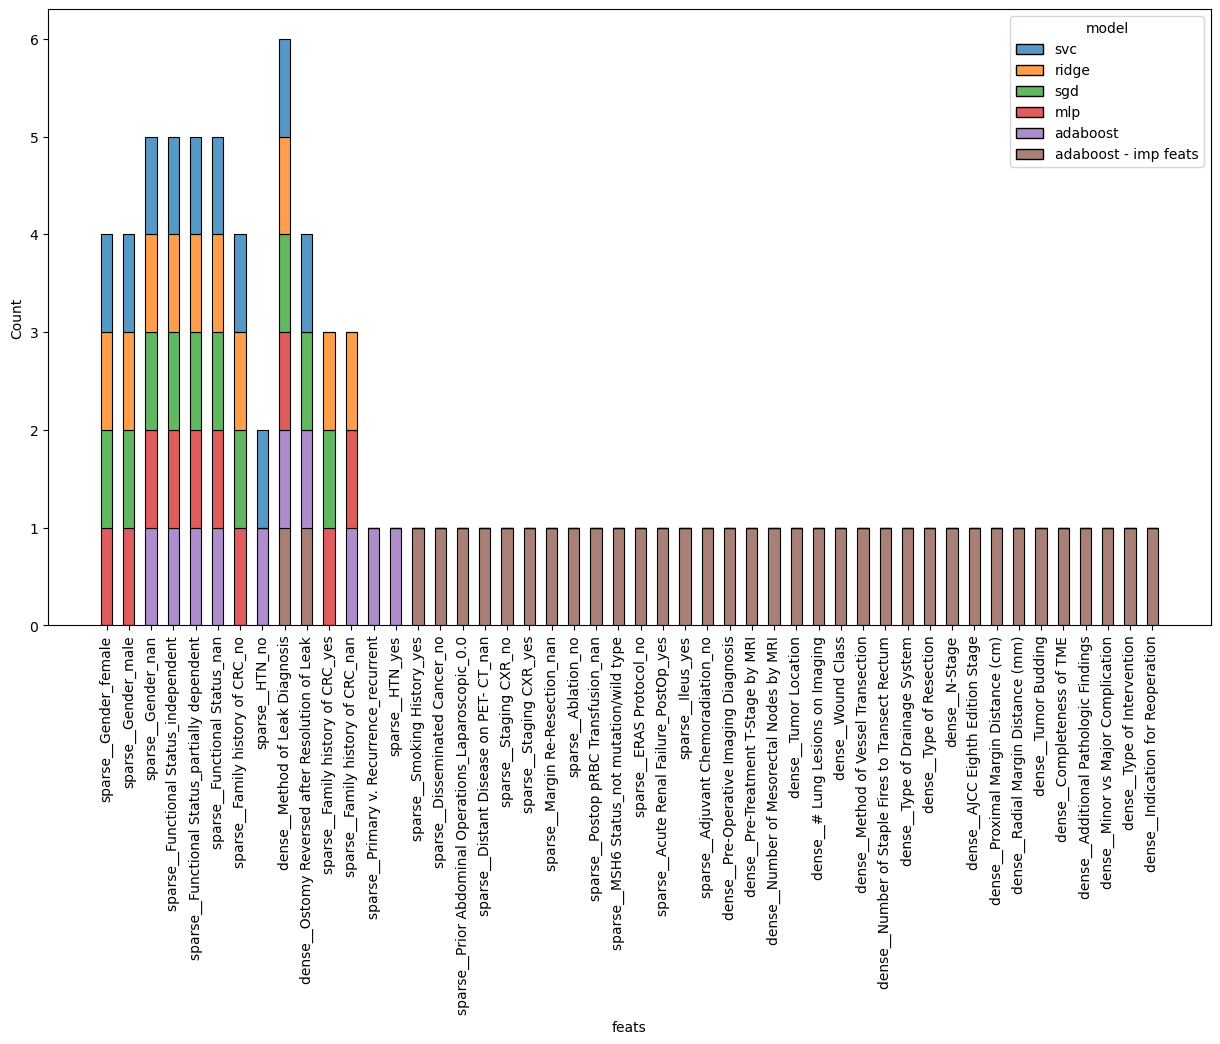

In [151]:
all_feats = {'feats': [], 'model': []}
for key, value in forward_results.items():
  all_feats['feats'].extend(value)
  all_feats['model'].extend(np.full_like(value, key).tolist())

all_feats['feats'].extend(boost_feats)
all_feats['model'].extend(np.full_like(boost_feats, 'adaboost - imp feats').tolist())

plt.figure(figsize=(15,8))
sns.histplot(data=all_feats, x='feats', stat="count", multiple="stack", element="bars", hue='model', legend=True, shrink=0.5)
plt.xticks(rotation="vertical")
plt.show()

## TODO: Reproduce statistical tests

In [ ]:
contingency_tab = pd.crosstab(leak_mvp['Omental Flap to Pelvis'], leak_mvp['Anastomotic Leak'], margins=False, dropna=False)
contingency_tab

Anastomotic Leak,no,yes,NaN
Omental Flap to Pelvis,,,
no,372,32,318
yes,74,9,20


In [ ]:
scipy.stats.chi2_contingency(contingency_tab)

Chi2ContingencyResult(statistic=23.591827257150264, pvalue=7.535287068704235e-06, dof=2, expected_freq=array([[390.31757576,  35.88121212, 295.80121212],
       [ 55.68242424,   5.11878788,  42.19878788]]))

In [ ]:
imp_leak = leak_mvp['Anastomotic Leak'].fillna('no')
contingency_tab = pd.crosstab(leak_mvp['Omental Flap to Pelvis'], imp_leak, margins=False, dropna=False)
contingency_tab

Anastomotic Leak,no,yes
Omental Flap to Pelvis,,
no,690,32
yes,94,9


In [ ]:
scipy.stats.chi2_contingency(contingency_tab)

Chi2ContingencyResult(statistic=2.685544408776171, pvalue=0.10126261252919086, dof=1, expected_freq=array([[686.11878788,  35.88121212],
       [ 97.88121212,   5.11878788]]))

In [ ]:
scipy.stats.chi2_contingency([[], []])

ValueError: No data; `observed` has size 0.